#### SPECK

# GOST Trace Capture

In [1]:
SCOPETYPE = 'OPENADC' # options: OPENADC, CWNANO  
PLATFORM = 'CW308_STM32F3' # options: CWLITEXMEGA/CW308_XMEGA, CWLITEARM/CW308_STM32F3, CWNANO 
CRYPTO_TARGET='NONE'
SS_VER='SS_VER_1_1'

In [2]:
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
scope.adc.samples = 5000 #options: 96000 for CW-PRO (CW1200), 24400 for CW-Lite, 131070 for CW-Husky
scope.adc.timeout = 2

In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../firmware/mcu/simpleserial-speck
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Size after:
   text	   data	    bss	    dec	    hex	filename
   5112	      8	   1448	   6568	   19a8	simpleserial-speck-CW308_STM32F3.elf
+--------------------------------------------------------
+ Built for platform CW308T: STM32F3 Target with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------


In [5]:
cw.program_target(scope, prog, "../../firmware/mcu/simpleserial-speck/simpleserial-speck-{}.hex".format(PLATFORM))

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5119 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5119 bytes


In [ ]:
import time
import numpy as np

# --- Сброс ---
print("Resetting target...")
scope.io.nrst = 'low'
time.sleep(0.2)
scope.io.nrst = 'high'
time.sleep(1.5)

target.flush()

# Или:
key_val = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07,
           0x08, 0x09, 0x0a, 0x0b, 0x0c, 0x0d, 0x0e, 0x0f]

print(f"Sending Key: {[hex(x) for x in key_val[:4]]}...")
target.simpleserial_write('k', bytearray(key_val))
time.sleep(0.2)

Resetting target...
Sending Key: ['0x0', '0x1', '0x2', '0x3']...
Ciphertext check: ['0x65', '0x1e', '0x9', '0xb7', '0x3', '0xef', '0x28', '0xd5', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
✅ УСПЕХ: Выходные данные изменились, ключ принят.


In [ ]:
from tqdm.notebook import trange
import numpy as np
from os import urandom

trace_array = []
textin_array = []

N = 2500

plaintexts = [urandom(16) for _ in range(N)]

for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', plaintexts[i])
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(plaintexts[i])

trace_array = np.array(trace_array)
print("Capture done.")

Capturing traces:   0%|          | 0/2500 [00:00<?, ?it/s]

Capture done.


In [8]:
scope.dis()
target.dis()

In [9]:
assert len(trace_array) == N
print("✔️ OK to continue!")

✔️ OK to continue!


Again, let's quickly plot a trace to make sure everything looks as expected:

<IPython.core.display.Javascript object>


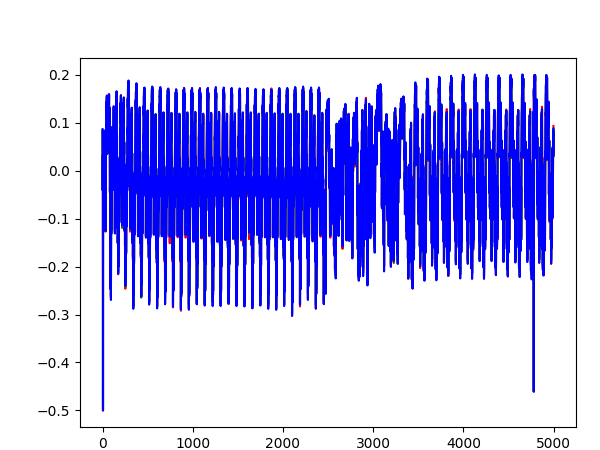

In [10]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace_array[0], 'r')
plt.plot(trace_array[N//2], 'g')
plt.plot(trace_array[N-1], 'b')
plt.show()

# GOST Model and Hamming Weight

In [11]:
## SPECK Model and Hamming Weight

# Таблица весов Хэмминга
HW = [bin(n).count("1") for n in range(0, 256)]

# Функция циклического сдвига вправо для 32 бит
def ror(x, n, bits=32):
    mask = (2**bits) - 1
    mask_bits = x & mask
    return (x >> n) | ((x << (bits - n)) & mask)

# Вспомогательные функции статистики (оставляем как были)
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

pt0_array = [] # Right word (y)
pt1_array = [] # Left word (x)

for text in textin_array:
    # Конвертация из байтов в 32-бит слова (Little Endian)
    p0 = int.from_bytes(text[0:4], byteorder='little') 
    p1 = int.from_bytes(text[4:8], byteorder='little')
    pt0_array.append(p0)
    pt1_array.append(p1)

pt0_array = np.array(pt0_array)
pt1_array = np.array(pt1_array)

# В SPECK мы атакуем первый раунд. Формула раунда:
x=(ROR(x,8)+y)⊕k
Поскольку операции 32-битные, мы будем восстанавливать первые 4 байта ключа (k[0]), учитывая перенос при сложении.

<IPython.core.display.Javascript object>


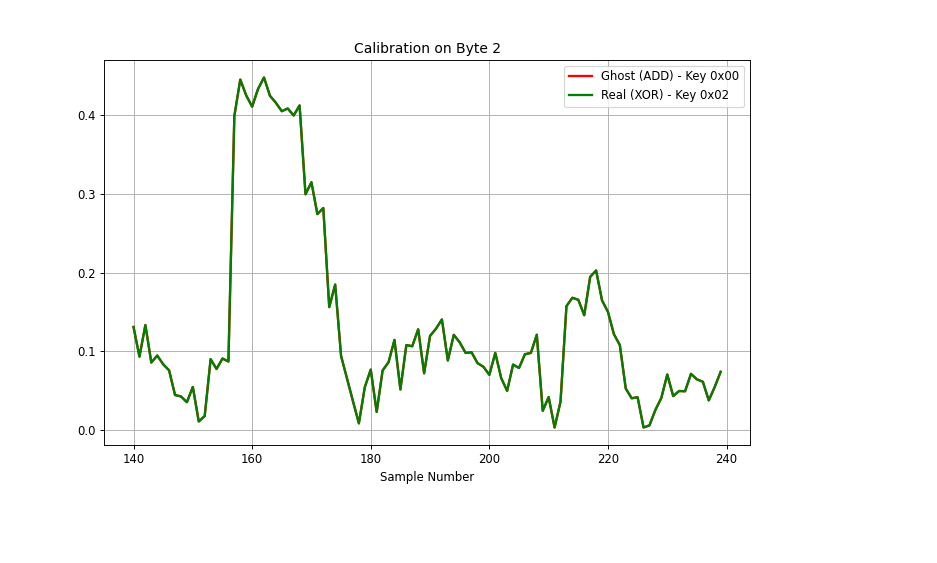

Пик ADD (0x00) на сэмпле: 162
Пик XOR (0x02) на сэмпле: 162
-> СДВИНЬТЕ ОКНО на 162!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Настраиваемся по Байтику №2 (где ключ 0x02)
target_byte = 2
real_key = 0x02    # Мы знаем, что там 0x02
ghost_key = 0x00   # Это утечка от ADD (которая нам мешает)

# Подготовка данных (пересчет модели)
rot = ((pt1_array >> 8) | (pt1_array << 24)) & 0xFFFFFFFF
sum_val = (rot + pt0_array) & 0xFFFFFFFF

# Две гипотезы
# 1. Сложение (ADD) - выглядит как ключ 0x00
hw_add = np.array([bin(((s ^ ghost_key) >> (8*target_byte)) & 0xFF).count('1') for s in sum_val])
# 2. Шифрование (XOR) - выглядит как ключ 0x02
hw_xor = np.array([bin(((s ^ real_key) >> (8*target_byte)) & 0xFF).count('1') for s in sum_val])

# Функция корреляции
def fast_corr(traces, hws):
    t_bar = traces - np.mean(traces, axis=0)
    h_bar = hws - np.mean(hws)
    return np.dot(h_bar, t_bar) / np.sqrt(np.sum(t_bar**2, axis=0) * np.sum(h_bar**2))

# Считаем (расширим окно анализа, чтобы точно найти XOR)
# Сканируем с 150 по 250 (подстройте под свой график, если нужно)
start_search = 140
end_search = 240
slice_traces = trace_array[:, start_search:end_search]

cpa_add = fast_corr(slice_traces, hw_add)
cpa_xor = fast_corr(slice_traces, hw_xor)

# Рисуем
plt.figure(figsize=(10, 6))
plt.plot(range(start_search, end_search), abs(cpa_add), 'r', label='Ghost (ADD) - Key 0x00', linewidth=2)
plt.plot(range(start_search, end_search), abs(cpa_xor), 'g', label='Real (XOR) - Key 0x02', linewidth=2)
plt.title(f"Calibration on Byte {target_byte}")
plt.xlabel("Sample Number")
plt.legend()
plt.grid(True)
plt.show()

# Вывод пиков текстом
peak_add = start_search + np.argmax(abs(cpa_add))
peak_xor = start_search + np.argmax(abs(cpa_xor))
print(f"Пик ADD (0x00) на сэмпле: {peak_add}")
print(f"Пик XOR (0x02) на сэмпле: {peak_xor}")
print(f"-> СДВИНЬТЕ ОКНО на {peak_xor}!")

<IPython.core.display.Javascript object>


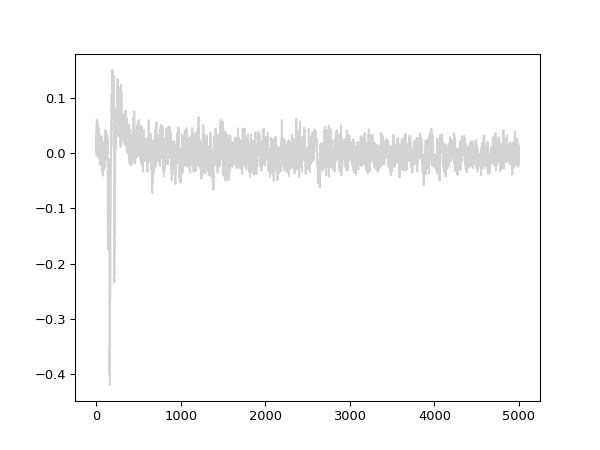

C:\Users\Vadim\AppData\Local\Temp\ipykernel_7500\1204838381.py:35: RuntimeWarning: invalid value encountered in divide
  cpaoutput = correlation/(o_t*o_hws)


Byte 0 Best Guess: 0xfe (Corr: 0.4217)
Byte 1 Best Guess: 0x00 (Corr: 0.4527)
Byte 2 Best Guess: 0x00 (Corr: 0.4475)
Byte 3 Best Guess: 0x00 (Corr: 0.4843)

Best Key Guess (First 4 bytes): fe 00 00 00 

In [17]:
t_bar = np.sum(trace_array, axis=0)/len(trace_array)
o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

bestguess = [0] * 4  # Мы атакуем первое слово ключа (4 байта)
cparefs = [0] * 4

plt.figure()

# Атакуем 4 байта первого раундового ключа последовательно

for bnum in range(4):
    maxcpa = [0] * 256
    
    for kguess in range(0, 256):
        # Формируем предполагаемое значение ключа (32 бита)
        key_guess_word = 0
        for i in range(bnum):
            key_guess_word |= (bestguess[i] << (8*i))
        key_guess_word |= (kguess << (8*bnum))
        
        # --- МОДЕЛЬ УТЕЧКИ SPECK ---
        
        rot_part = ( (pt1_array >> 8) | (pt1_array << 24) ) & 0xFFFFFFFF
        sum_part = (rot_part + pt0_array) & 0xFFFFFFFF
        intermediate = (sum_part ^ key_guess_word)
        
        # Выделяем целевой байт результата для HW
        target_byte = (intermediate >> (8*bnum)) & 0xFF
        
        # Считаем корреляцию
        hws = np.array([[HW[val] for val in target_byte]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        
        maxcpa[kguess] = max(abs(cpaoutput[210:230]))
        
        if bnum == 0 and kguess == 0: # Инициализация графика
             plt.plot(cpaoutput, 'lightgrey')

    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)
    print(f"Byte {bnum} Best Guess: 0x{bestguess[bnum]:02x} (Corr: {cparefs[bnum]:.4f})")

plt.show()

print("\nBest Key Guess (First 4 bytes): ", end="")
for b in bestguess: print("%02x " % b, end="")

With one final check to make sure you've got the correct key:

NameError: name 'key' is not defined